# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Load Data

In [ ]:
# Processing, Loading, and Padding the data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def pad_slices(scan, target_slices= 50):
    # Get the current number of slices
    current_slices = scan.shape[0]
    # Check if padding is necessary
    if current_slices < target_slices:
        # Calculate padding amounts
        pad_before = (target_slices - current_slices) // 2
        pad_after = target_slices - current_slices - pad_before
        # Pad the scan with zeros on the slices axis (axis 0)
        padded_scan = np.pad(scan, pad_width=((pad_before, pad_after), (0, 0), (0, 0)), mode='constant', constant_values=0)
    elif current_slices > target_slices:
        # Calculate the cropping needed
        start = (current_slices - target_slices) // 2
        end = start + target_slices
        # Crop the scan to the target size
        padded_scan = scan[start:end, :, :]
    else:
        # If the number of slices is already equal to the target, no action is needed
        padded_scan = scan
    return padded_scan


def process_and_save_scan(path_to_scan, target_slices=50, save_dir=''):
    scan = np.load(path_to_scan, allow_pickle=True)
    padded_scan = pad_slices(scan, target_slices=target_slices)
    # Define the save path
    save_path = os.path.join(save_dir, os.path.basename(path_to_scan))
    # Save the processed scan to a new file
    np.save(save_path, padded_scan)
    # Free up memory immediately
    del scan, padded_scan

def load_data(target_slices=50, save_processed=False, processed_prefix='processed_'):
    # Directories for axial, coronal, and sagittal scans
    directories = ['data/axial', 'data/coronal', 'data/sagittal']
    data_all_angles = []

    for directory in directories:
        processed_scans = []
        for scan_file in sorted(os.listdir(directory)):
            if scan_file.endswith('.npy'):
                path_to_scan = os.path.join(directory, scan_file)
                
                # Define processed file path
                processed_file_name = f'{processed_prefix}{scan_file}'
                processed_file_path = os.path.join(directory, processed_file_name)

                # Check if processed file exists
                if os.path.isfile(processed_file_path):
                    # Load processed scan
                    processed_scan = np.load(processed_file_path)
                else:
                    # Load and process original scan
                    scan = np.load(path_to_scan, allow_pickle=True)
                    processed_scan = pad_slices(scan, target_slices)

                    # Optionally save the processed scan to disk
                    if save_processed:
                        np.save(processed_file_path, processed_scan)

                    # Free up memory
                    del scan

                processed_scans.append(processed_scan)

        # Add the processed scans for the current angle to the data_all_angles list
        data_all_angles.append(processed_scans)

    # Now stack the processed data from different angles
    combined_data = [np.stack((axial, coronal, sagittal), axis=-1) 
                     for axial, coronal, sagittal in zip(*data_all_angles)]

    # Load labels
    labels_abnormal = pd.read_csv('labels/train-abnormal.csv')
    labels_acl = pd.read_csv('labels/train-acl.csv')
    labels_meniscus = pd.read_csv('labels/train-meniscus.csv')

    # Combine labels into a single array
    combined_labels = np.vstack((labels_abnormal.iloc[:,1], labels_acl.iloc[:,1], labels_meniscus.iloc[:,1])).T

    return np.array(combined_data), combined_labels


# Use the load_data function
data, labels = load_data(save_processed=True)

## Use to display data

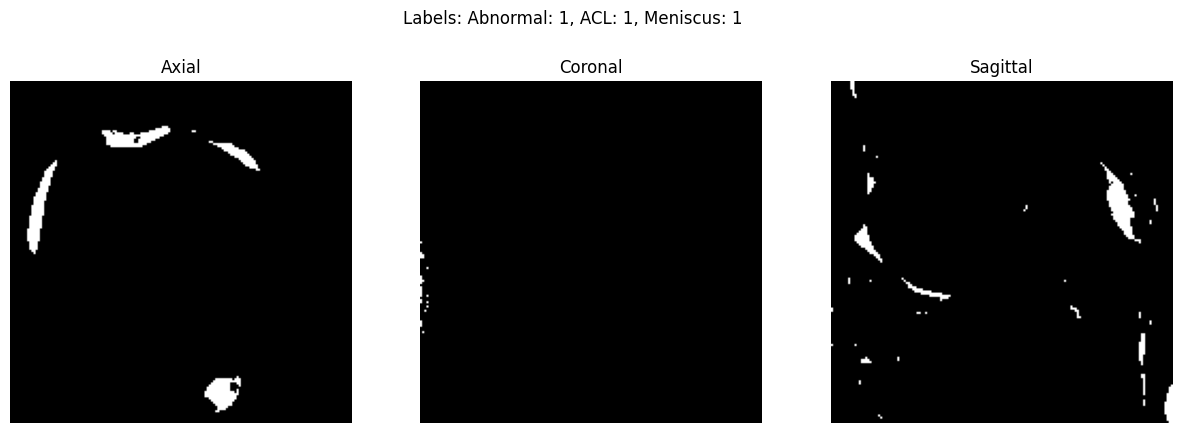

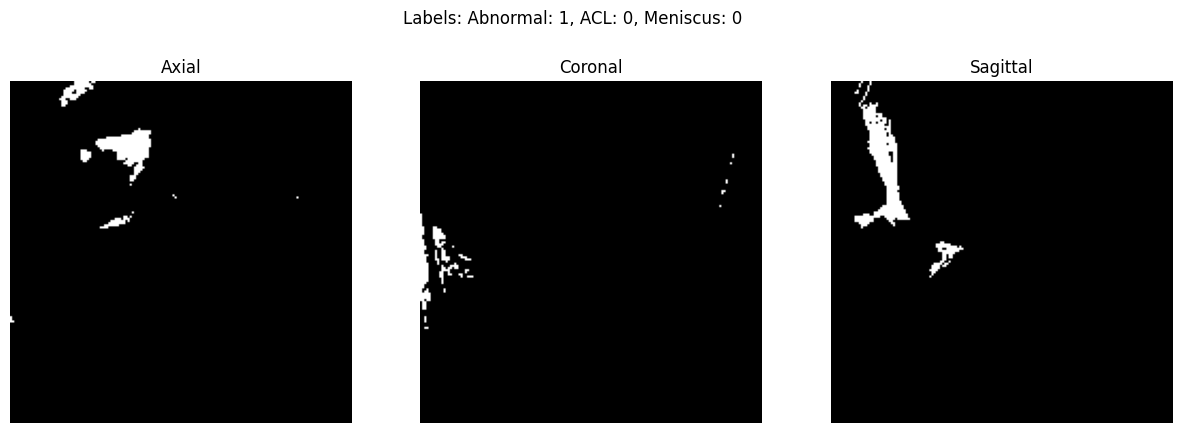

In [13]:

def display_data(data, labels):
    # Display the first image of each angle from the combined data along with the labels
    for i in range(len(data)):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        # The data shape is expected to be (slices, 255, 255, angles)
        # We will display the middle slice for each angle.
        middle_slice_index = data[i].shape[0] // 2

        for j, title in enumerate(['Axial', 'Coronal', 'Sagittal']):
            # Extract the middle slice for the current angle
            image = data[i][middle_slice_index, :, :, j]
            
            axs[j].imshow(image, cmap='gray')
            axs[j].axis('off')  # Turn off axis
            axs[j].title.set_text(title)

        label_names = ['Abnormal', 'ACL', 'Meniscus']
        label_str = ', '.join(f'{name}: {value}' for name, value in zip(label_names, labels[i]))
        plt.suptitle(f'Labels: {label_str}')

        # Show the plot
        plt.show()

        # Break after the first set of images for brevity
        if i == 1:
            break





# Display data and labels
display_data(data, labels)

# 3. Preprocess Data (Crop, Scale, Augment)

## Cropping the Data to 160 x 160

In [7]:
import numpy as np

def crop_center(img, cropx, cropy):
    # Assuming img has shape (slices, height, width, channels)
    d, y, x, c = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    
    # Ensure the cropped image has the same number of channels
    return img[:, starty:starty+cropy, startx:startx+cropx, :]

# Assuming 'data' is your array of MRI scans
batch_size = 10  # Set your batch size

# Initialize a new array to hold the cropped images
cropped_data = np.zeros((data.shape[0], data.shape[1], 160, 160, data.shape[-1]), dtype=data.dtype)

# Loop over the data in batches for cropping
for start in range(0, len(data), batch_size):
    end = start + batch_size
    batch = data[start:end]

    # Apply cropping to each image in the batch
    cropped_batch = np.array([crop_center(img, 160, 160) for img in batch])

    # Update the cropped_data array with the cropped_batch
    cropped_data[start:end] = cropped_batch

    # Feedback to user
    print(f"Cropped batch from index {start} to {end}")

# Now 'cropped_data' contains the cropped images
# You can continue to use 'cropped_data' for further processing such as scaling


Cropped batch from index 0 to 10
Cropped batch from index 10 to 20
Cropped batch from index 20 to 30
Cropped batch from index 30 to 40
Cropped batch from index 40 to 50
Cropped batch from index 50 to 60
Cropped batch from index 60 to 70
Cropped batch from index 70 to 80
Cropped batch from index 80 to 90
Cropped batch from index 90 to 100
Cropped batch from index 100 to 110
Cropped batch from index 110 to 120
Cropped batch from index 120 to 130
Cropped batch from index 130 to 140
Cropped batch from index 140 to 150
Cropped batch from index 150 to 160
Cropped batch from index 160 to 170
Cropped batch from index 170 to 180
Cropped batch from index 180 to 190
Cropped batch from index 190 to 200
Cropped batch from index 200 to 210
Cropped batch from index 210 to 220
Cropped batch from index 220 to 230
Cropped batch from index 230 to 240
Cropped batch from index 240 to 250
Cropped batch from index 250 to 260
Cropped batch from index 260 to 270
Cropped batch from index 270 to 280
Cropped batc

## Scaling the data based on max batch value (instead of 255)

In [12]:

import numpy as np

# Calculate the batch size that your memory can handle, e.g., 100
batch_size = 10

# Loop over the data in batches for normalization
for start in range(0, len(cropped_data), batch_size):
    end = start + batch_size
    batch = cropped_data[start:end]

    # Calculate the min and max for the current batch
    batch_min = batch.min()
    batch_max = batch.max()

    # Normalize the batch and update the data in-place
    cropped_data[start:end] = (batch.astype(np.float32) - batch_min) / (batch_max - batch_min)

    # Feedback to user
    print(f"Processed and normalized batch from index {start} to {end}")


Processed and normalized batch from index 0 to 10
Processed and normalized batch from index 10 to 20
Processed and normalized batch from index 20 to 30
Processed and normalized batch from index 30 to 40
Processed and normalized batch from index 40 to 50
Processed and normalized batch from index 50 to 60
Processed and normalized batch from index 60 to 70
Processed and normalized batch from index 70 to 80
Processed and normalized batch from index 80 to 90
Processed and normalized batch from index 90 to 100
Processed and normalized batch from index 100 to 110
Processed and normalized batch from index 110 to 120
Processed and normalized batch from index 120 to 130
Processed and normalized batch from index 130 to 140
Processed and normalized batch from index 140 to 150
Processed and normalized batch from index 150 to 160
Processed and normalized batch from index 160 to 170
Processed and normalized batch from index 170 to 180
Processed and normalized batch from index 180 to 190
Processed and

In [ ]:
data = cropped_data[:-1]

In [ ]:
del cropped_data

## Data Augmentation 

In [9]:


import numpy as np
import random

def random_rotation(img, max_angle):
    # Rotate image by a random angle within the range [-max_angle, max_angle]
    k = random.choice([0, 1, 2, 3])  # Rotates by 0, 90, 180, or 270 degrees
    return np.rot90(img, k=k, axes=(0, 1))  # Rotate on the (height, width) plane

def horizontal_flip(img, flip_prob):
    # Flip image horizontally with a given probability
    if random.random() < flip_prob:
        return np.flip(img, axis=1)  # Flip on the width axis
    return img

# Set your batch size and other parameters
batch_size = 10
max_angle = 1  # For np.rot90, the angle is in multiples of 90 degrees
flip_prob = 0.5

# Assuming 'data' is your array of MRI scans with shape (num_scans, num_slices, height, width, channels)
for start in range(0, len(data), batch_size):
    end = min(start + batch_size, len(data))
    batch = data[start:end]

    # Apply augmentation to each slice in each scan
    augmented_batch = np.empty_like(batch)
    for scan_idx, scan in enumerate(batch):
        for slice_idx, img_slice in enumerate(scan):
            # Ensure the slice has no channel dimension for augmentation functions
            img_slice_2d = img_slice[..., 0] if img_slice.ndim == 3 else img_slice
            rotated = random_rotation(img_slice_2d, max_angle)
            flipped = horizontal_flip(rotated, flip_prob)
            # If the original slice had a channel dimension, we need to expand the dimensions of the augmented slice
            augmented_batch[scan_idx, slice_idx] = np.expand_dims(flipped, axis=-1) if img_slice.ndim == 3 else flipped
    
    # Update the original data array with the augmented batch
    data[start:end] = augmented_batch

    print(f"Augmented batch from index {start} to {end}")


Augmented batch from index 0 to 10
Augmented batch from index 10 to 20
Augmented batch from index 20 to 30
Augmented batch from index 30 to 40
Augmented batch from index 40 to 50
Augmented batch from index 50 to 60
Augmented batch from index 60 to 70
Augmented batch from index 70 to 80
Augmented batch from index 80 to 90
Augmented batch from index 90 to 100
Augmented batch from index 100 to 110
Augmented batch from index 110 to 120
Augmented batch from index 120 to 130
Augmented batch from index 130 to 140
Augmented batch from index 140 to 150
Augmented batch from index 150 to 160
Augmented batch from index 160 to 170
Augmented batch from index 170 to 180
Augmented batch from index 180 to 190
Augmented batch from index 190 to 200
Augmented batch from index 200 to 210
Augmented batch from index 210 to 220
Augmented batch from index 220 to 230
Augmented batch from index 230 to 240
Augmented batch from index 240 to 250
Augmented batch from index 250 to 260
Augmented batch from index 260 t

# Split Data

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
data.shape[0]

1129

In [17]:
labels.shape[0]

1129

In [19]:
# Assuming data and labels are numpy arrays
total_size = data.shape[0]

# Calculate the indices for splitting
train_end = int(train_size)
val_end = train_end + int(val_size)

# Split the data
trainD = data[:train_end]
valD = data[train_end:val_end]
testD = data[val_end:]

# Split the labels
trainL = labels[:train_end]
valL = labels[train_end:val_end]
testL = labels[val_end:]

# Create tuples for easy handling
train = (trainD, trainL)
validation = (valD, valL)
test = (testD, testL)

# Check the shape of the datasets
print('Training set shape:', trainD.shape)
print('Validation set shape:', valD.shape)
print('Test set shape:', testD.shape)

Training set shape: (790, 50, 160, 160, 3)
Validation set shape: (225, 50, 160, 160, 3)
Test set shape: (114, 50, 160, 160, 3)


## Data Generator (generates data in a sequence to help with training memory load)

In [102]:
from tensorflow.keras.utils import Sequence

In [103]:
class MRISequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array(batch_x), np.array(batch_y)

In [104]:
# Assuming 'trainD' and 'trainL' are paths to your data or some lazy loading mechanism
train_seq = MRISequence(trainD, trainL, batch_size=5)  # Adjust batch_size to a suitable value for your hardware

# 4. Build Deep Learning Model

## Test 5 (imageclassifier6.h5) (Used test 4 model) it gave the same result as test 2, but the file size was too large due to using Sequential model)

In [ ]:


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

model = Sequential()

input_shape = (50, 160, 160, 3)
inputs = Input(shape=input_shape)

x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', 
           kernel_regularizer=l2(0.01))(inputs)
x = BatchNormalization()(x)
x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)

x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same', 
           kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)

x = Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same', 
           kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)

x = Flatten()(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

outputs = Dense(3, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(multi_label=True)])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Model Summary
model.summary()


## Test 2 (imageclassifier2.h5) and Test 3 (Did not save) Model Build 

## Note: for Test 3 we simply increased regularizer values to 0.02

In [29]:



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping



model = Sequential()



input_shape = (50, 160, 160, 3)

# Input Conv3D layer
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape,
                 padding='same', kernel_regularizer=l2(0.01)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

# Additional Conv3D and MaxPooling3D layers
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.01)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.01)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

# Flatten the output to feed into the dense layers
model.add(Flatten())

# Dense layer with dropout and regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Output layer for multi-label classification
model.add(Dense(3, activation='sigmoid'))  # Assuming 3 classes for the output layer

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               verbose=1, 
                               restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

# Model Summary
model.summary()

## Test 4 Model Build (imageclassifier5.h5)

In [18]:

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, GlobalMaxPooling3D
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.layers import add
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

def conv_block(x, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu', batch_norm=True, reg=l2(0.01)):
    conv = Conv3D(filters, kernel_size, padding='same', strides=strides, kernel_regularizer=reg)(x)
    if batch_norm:
        conv = BatchNormalization()(conv)
    if activation:
        conv = Activation(activation)(conv)
    return conv

def residual_block(x, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu', batch_norm=True, reg=l2(0.01)):
    # Shortcut
    shortcut = x
    if strides != (1, 1, 1) or x.shape[-1] != filters:
        shortcut = Conv3D(filters, (1, 1, 1), padding='same', strides=strides, kernel_regularizer=reg)(x)
        if batch_norm:
            shortcut = BatchNormalization()(shortcut)

    # Residual path
    x = conv_block(x, filters, kernel_size, strides, activation, batch_norm, reg)
    x = conv_block(x, filters, kernel_size, activation=None, batch_norm=batch_norm, reg=reg)

    # Add shortcut value to main path
    x = add([shortcut, x])
    if activation:
        x = Activation(activation)(x)
    return x

# Input layer
input_shape = (50, 160, 160, 3)
inputs = Input(shape=input_shape)

# First Convolutional Block
x = conv_block(inputs, 32, kernel_size=(7, 7, 7), strides=(2, 2, 2))

# MaxPooling
x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)

# Residual Blocks - adjust the number of blocks and filters based on the successful study
x = residual_block(x, 64)
x = residual_block(x, 64)
x = Dropout(0.5)(x)

# Additional Residual Blocks if needed
# x = residual_block(x, 128)
# x = Dropout(0.5)(x)
# ... repeat as necessary ...

# Transition to the fully connected layer with GlobalMaxPooling
x = GlobalMaxPooling3D()(x)

# Fully Connected Layer
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

# Output Layer
outputs = Dense(3, activation='sigmoid')(x)  # Assuming 3 classes for the output layer

# Model definition
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Model Summary
model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 160, 160, 3)]    0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 25, 80, 80, 32)       32960     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 25, 80, 80, 32)       128       ['conv3d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 25, 80, 80, 32)       0         ['batch_normalization[0

# 5. Train

In [32]:
# train loss / validation should go down, train accuracy and validation accuracy should go up

In [105]:
# Fit the model with early stopping
history = model.fit(train_seq, 
                    epochs=15, # Adjust the number of epochs as necessary
                    verbose=1, 
                    validation_data= validation,
                    callbacks=[early_stopping])

Epoch 1/15
158/158 [==============================] - 463s 3s/step - loss: 12.8487 - accuracy: 0.8329 - auc: 0.6819 - val_loss: 8.5101 - val_accuracy: 1.0000 - val_auc: 0.7734
Epoch 2/15
158/158 [==============================] - 458s 3s/step - loss: 6.3859 - accuracy: 0.9633 - auc: 0.7499 - val_loss: 4.7885 - val_accuracy: 1.0000 - val_auc: 0.7794
Epoch 3/15
158/158 [==============================] - 457s 3s/step - loss: 3.7647 - accuracy: 0.9722 - auc: 0.7612 - val_loss: 3.0085 - val_accuracy: 1.0000 - val_auc: 0.7676
Epoch 4/15
158/158 [==============================] - 447s 3s/step - loss: 2.4723 - accuracy: 0.9861 - auc: 0.7631 - val_loss: 2.4743 - val_accuracy: 0.0000e+00 - val_auc: 0.5711
Epoch 5/15
158/158 [==============================] - 445s 3s/step - loss: 1.8305 - accuracy: 0.9899 - auc: 0.7604 - val_loss: 1.5821 - val_accuracy: 1.0000 - val_auc: 0.7741
Epoch 6/15
158/158 [==============================] - 440s 3s/step - loss: 1.3834 - accuracy: 0.9937 - auc: 0.7594 - val

In [120]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
anyio                        4.1.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.13.1
beautifulsoup4               4.12.2
bleach                       6.1.0
cachetools                   5.3.2
certifi                      2023.11.17
cffi                         1.16.0
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.0
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.0
executing                    2.0.1
fastjsonschema               2.19.

# Save and Plot Performance

In [75]:
from tensorflow.keras.models import load_model

In [106]:
model.save(os.path.join('models','imageclassifier7.h5'))

C:\Users\Jack\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


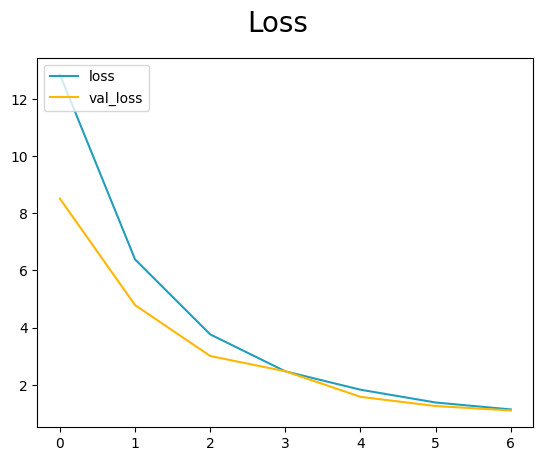

In [107]:
# Plot for loss
fig = plt.figure()
plt.plot(history.history['loss'], color='#219EBC', label='loss')  # Blue Green color
plt.plot(history.history['val_loss'], color='#FFB703', label='val_loss')  # Selective Yellow color
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

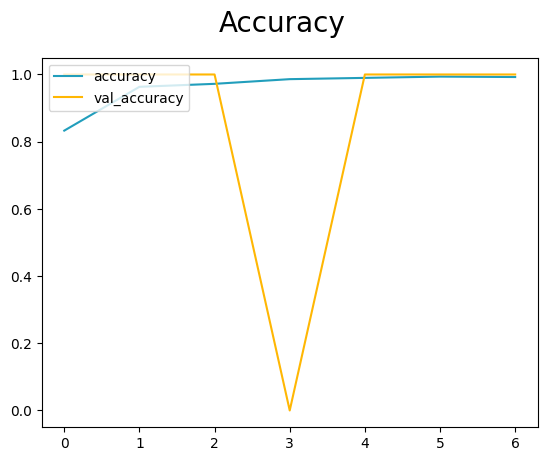

In [108]:
# Plot for accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='#219EBC', label='accuracy')  # Blue Green color
plt.plot(history.history['val_accuracy'], color='#FFB703', label='val_accuracy')  # Selective Yellow color
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 6. Evaluate

In [109]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC

In [110]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [111]:
batch_size = 5

for i in range(0, len(test[0]), batch_size):  # test[0] is the data component of the test set
    # Create a batch of data and labels
    X, y = test[0][i:i+batch_size], test[1][i:i+batch_size]
    
    # Make predictions
    yhat = model.predict(X)
    
    # Update metrics
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


# Calculate final results
precision_result = pre.result().numpy()
recall_result = re.result().numpy()
accuracy_result = acc.result().numpy()
auc_result = auc.result().numpy()

# Print results
print(f'Precision: {precision_result:.4f}, Recall: {recall_result:.4f}, Accuracy: {accuracy_result:.4f})

1/1 [==============================] - 1s 609ms/step
Precision: 0.6022, Recall: 0.7619, Accuracy: 0.6813, AUC: 0.5041


# 7. Save the Model using TFlite (optional)

In [99]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# Initialize TFLiteConverter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Indicate that TensorFlow ops are allowed (enables the use of Flex ops)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # Enable TensorFlow ops.
]

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = os.path.join('models', 'model6.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f'Model is successfully converted to TensorFlow Lite and saved at {tflite_model_path}')


INFO:tensorflow:Assets written to: C:\Users\Jack\AppData\Local\Temp\tmp4d4b3_l1\assets


INFO:tensorflow:Assets written to: C:\Users\Jack\AppData\Local\Temp\tmp4d4b3_l1\assets


Model is successfully converted to TensorFlow Lite and saved at models\model6.tflite


# 8. Load an Existing Model

In [96]:
from tensorflow.keras.models import load_model
import os

# Assuming 'imageclassifier6.h5' is the filename of your saved model
model_path = os.path.join('models', 'imageclassifier6.h5')
model = load_model(model_path)